LOADING VGG16 MODEL

In [ ]:
import torch
import torchvision.models as models

# Load the pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Set the model to evaluation mode if you are just using it for inference
vgg16.eval()

# If you want to fine-tune the model on a custom dataset, set it to train mode
vgg16.train()


In [7]:
class CustomVGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomVGG16, self).__init__()
        
        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)
        
        # Extract the features and avgpool layers
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool
        
        # Define a new classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # Adjust input size for VGG16's avgpool output
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        # Pass through feature layers
        x = self.features(x)
        
        # Pass through avgpool layer
        x = self.avgpool(x)
        
        # Reshape the output to a 2D tensor (batch_size, 512*7*7)
        x = torch.flatten(x, 1)  # Flatten from (batch_size, 512, 7, 7) to (batch_size, 512*7*7)
        
        # Pass through the custom classifier
        x = self.classifier(x)
        
        return x
    
    


In [8]:
model=CustomVGG16(num_classes=2)
print(model)

CustomVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

**Early Stopping function**

In [9]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to save the best model. 
                            Default: 'checkpoint.pt'
            trace_func (function): Function to print trace messages.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf  # Set to infinity to ensure the first comparison
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        """Check if early stopping condition is met and save the model if there's improvement."""
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            self.trace_func(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time


**Train dataset using pretrained vgg16 model**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time

# Image dimensions and data directories
img_size = 224
train_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/train'
val_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/val'
test_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/test'

# Data transformations for augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def create_vgg16_model(num_classes):
    model = models.vgg16(pretrained=True)
    
    # Freeze the convolutional layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Modify the classifier to match the number of classes
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    
    return model

def train_vgg16(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):
    model = model.to(device)
    best_accuracy = 0.0
    best_model_wts = model.state_dict()
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Track statistics
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
        # Save the model if it has the best accuracy so far
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = model.state_dict()
            early_stop_counter = 0  # Reset counter when validation improves
        else:
            early_stop_counter += 1
        
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break
    
    # Load the best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_vgg16_model.pth')
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

def test_vgg16(model, test_loader, device):
    model.eval()
    test_corrects = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
    
    test_acc = test_corrects.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model, define criterion and optimizer
num_classes = len(train_dataset.classes)
model = create_vgg16_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

# Train the model with early stopping
train_vgg16(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5)

# Load the best model for testing
model.load_state_dict(torch.load('best_vgg16_model.pth'))

# Test the model
test_vgg16(model, test_loader, device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 217MB/s] 


Epoch 1/50
Training Loss: 0.4770, Training Accuracy: 0.7699
Validation Loss: 0.3967, Validation Accuracy: 0.8210
Epoch 2/50
Training Loss: 0.4318, Training Accuracy: 0.7889
Validation Loss: 0.3840, Validation Accuracy: 0.8336
Epoch 3/50
Training Loss: 0.4118, Training Accuracy: 0.8019
Validation Loss: 0.3311, Validation Accuracy: 0.8477
Epoch 4/50
Training Loss: 0.3954, Training Accuracy: 0.8112
Validation Loss: 0.3439, Validation Accuracy: 0.8457
Epoch 5/50
Training Loss: 0.3873, Training Accuracy: 0.8120
Validation Loss: 0.3313, Validation Accuracy: 0.8421
Epoch 6/50
Training Loss: 0.3788, Training Accuracy: 0.8213
Validation Loss: 0.3406, Validation Accuracy: 0.8411
Epoch 7/50
Training Loss: 0.3599, Training Accuracy: 0.8340
Validation Loss: 0.3676, Validation Accuracy: 0.8316
Epoch 8/50
Training Loss: 0.3545, Training Accuracy: 0.8325
Validation Loss: 0.5324, Validation Accuracy: 0.7707
Early stopping triggered.
Best Validation Accuracy: 0.8477


/tmp/ipykernel_30/1521905461.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vgg16_model.pth'))


Test Accuracy: 0.7469


**VGG16 test accuracy = 74.69%**

**Train dataset using pretrained RESNET50 model**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time

# Image dimensions and data directories
img_size = 224
train_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/train'
val_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/val'
test_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/test'

# Data transformations for augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to create ResNet-50 model
def create_resnet50_model(num_classes):
    model = models.resnet50(pretrained=True)
    
    # Freeze the convolutional layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the fully connected layer to match the number of classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

# Training function for ResNet-50
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):
    model = model.to(device)
    best_accuracy = 0.0
    best_model_wts = model.state_dict()
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Track statistics
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
        # Save the model if it has the best accuracy so far
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = model.state_dict()
            early_stop_counter = 0  # Reset counter when validation improves
        else:
            early_stop_counter += 1
        
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break
    
    # Load the best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_resnet50_model.pth')
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Test the model
def test_model(model, test_loader, device):
    model.eval()
    test_corrects = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
    
    test_acc = test_corrects.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create ResNet-50 model, define criterion and optimizer
num_classes = len(train_dataset.classes)
model = create_resnet50_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

# Train the model with early stopping
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5)

# Load the best model for testing
model.load_state_dict(torch.load('best_resnet50_model.pth'))

# Test the model
test_model(model, test_loader, device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s] 


Epoch 1/50
Training Loss: 0.5552, Training Accuracy: 0.7312
Validation Loss: 0.3972, Validation Accuracy: 0.8376
Epoch 2/50
Training Loss: 0.5327, Training Accuracy: 0.7389
Validation Loss: 0.3741, Validation Accuracy: 0.8451
Epoch 3/50
Training Loss: 0.5159, Training Accuracy: 0.7514
Validation Loss: 0.3754, Validation Accuracy: 0.8693
Epoch 4/50
Training Loss: 0.5130, Training Accuracy: 0.7498
Validation Loss: 0.3614, Validation Accuracy: 0.8678
Epoch 5/50
Training Loss: 0.5122, Training Accuracy: 0.7514
Validation Loss: 0.3700, Validation Accuracy: 0.8703
Epoch 6/50
Training Loss: 0.5069, Training Accuracy: 0.7557
Validation Loss: 0.3686, Validation Accuracy: 0.8537
Epoch 7/50
Training Loss: 0.5044, Training Accuracy: 0.7575
Validation Loss: 0.3727, Validation Accuracy: 0.8678
Epoch 8/50
Training Loss: 0.5048, Training Accuracy: 0.7564
Validation Loss: 0.3712, Validation Accuracy: 0.8472
Epoch 9/50
Training Loss: 0.5019, Training Accuracy: 0.7587
Validation Loss: 0.3687, Validation 

/tmp/ipykernel_30/3061515565.py:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet50_model.pth'))


Test Accuracy: 0.7288


**RESNET50 test accuracy = 72.88**

**Train dataset using pretrained RESNET18 model**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time

# Image dimensions and data directories
img_size = 224
train_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/train'
val_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/val'
test_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/test'

# Data transformations for augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to create ResNet-18 model
def create_resnet18_model(num_classes):
    model = models.resnet18(pretrained=True)
    
    # Freeze the convolutional layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the fully connected layer to match the number of classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

# Training function for ResNet-18
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):
    model = model.to(device)
    best_accuracy = 0.0
    best_model_wts = model.state_dict()
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Track statistics
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
        # Save the model if it has the best accuracy so far
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = model.state_dict()
            early_stop_counter = 0  # Reset counter when validation improves
        else:
            early_stop_counter += 1
        
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break
    
    # Load the best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_resnet18_model.pth')
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Test the model
def test_model(model, test_loader, device):
    model.eval()
    test_corrects = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
    
    test_acc = test_corrects.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create ResNet-18 model, define criterion and optimizer
num_classes = len(train_dataset.classes)
model = create_resnet18_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

# Train the model with early stopping
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5)

# Load the best model for testing
model.load_state_dict(torch.load('best_resnet18_model.pth'))

# Test the model
test_model(model, test_loader, device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.8MB/s]


Epoch 1/50
Training Loss: 0.5745, Training Accuracy: 0.7213
Validation Loss: 0.4613, Validation Accuracy: 0.7989
Epoch 2/50
Training Loss: 0.5414, Training Accuracy: 0.7400
Validation Loss: 0.4257, Validation Accuracy: 0.8039
Epoch 3/50
Training Loss: 0.5263, Training Accuracy: 0.7465
Validation Loss: 0.4146, Validation Accuracy: 0.8240
Epoch 4/50
Training Loss: 0.5189, Training Accuracy: 0.7501
Validation Loss: 0.4189, Validation Accuracy: 0.8240
Epoch 5/50
Training Loss: 0.5188, Training Accuracy: 0.7489
Validation Loss: 0.4329, Validation Accuracy: 0.8165
Epoch 6/50
Training Loss: 0.5122, Training Accuracy: 0.7538
Validation Loss: 0.4083, Validation Accuracy: 0.8170
Epoch 7/50
Training Loss: 0.5126, Training Accuracy: 0.7504
Validation Loss: 0.4116, Validation Accuracy: 0.8230
Epoch 8/50
Training Loss: 0.5108, Training Accuracy: 0.7528
Validation Loss: 0.4251, Validation Accuracy: 0.8165
Early stopping triggered.
Best Validation Accuracy: 0.8240


/tmp/ipykernel_30/2149583611.py:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet18_model.pth'))


Test Accuracy: 0.7548


**Resnet18 test accuracy = 75%**

print,plot statement in test functions of the code given below plot_auc,plot_confusion_matrix should be defined outside testing function and make sure that the number of arguments that you are passing to test arguments is equal to the arguments you have defined.

**VGG16 (AUC,CONFUSION_MATRIX)**

**VGG 16**

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 222MB/s] 


Epoch 1/50
Training Loss: 0.4814, Training Accuracy: 0.7657
Validation Loss: 0.3529, Validation Accuracy: 0.8446
Epoch 2/50
Training Loss: 0.4338, Training Accuracy: 0.7955
Validation Loss: 0.3708, Validation Accuracy: 0.8200
Epoch 3/50
Training Loss: 0.4068, Training Accuracy: 0.8071
Validation Loss: 0.4167, Validation Accuracy: 0.8039
Epoch 4/50
Training Loss: 0.3926, Training Accuracy: 0.8126
Validation Loss: 0.3627, Validation Accuracy: 0.8391
Epoch 5/50
Training Loss: 0.3877, Training Accuracy: 0.8157
Validation Loss: 0.3989, Validation Accuracy: 0.8200
Epoch 6/50
Test Accuracy: 0.7799


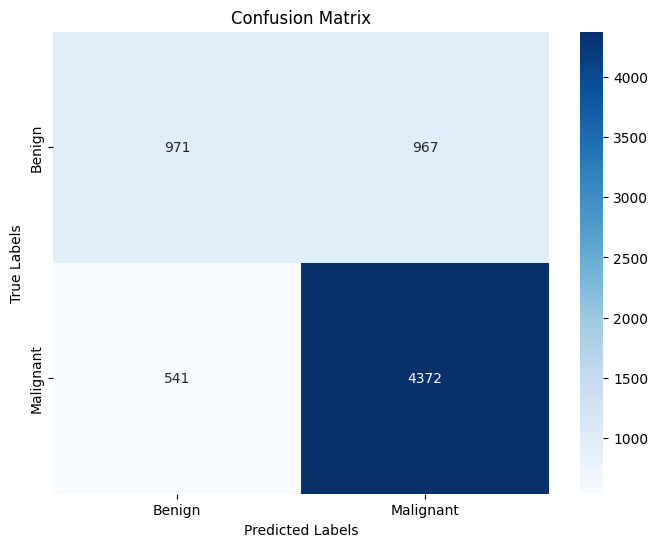

ROC AUC Score: 0.7902


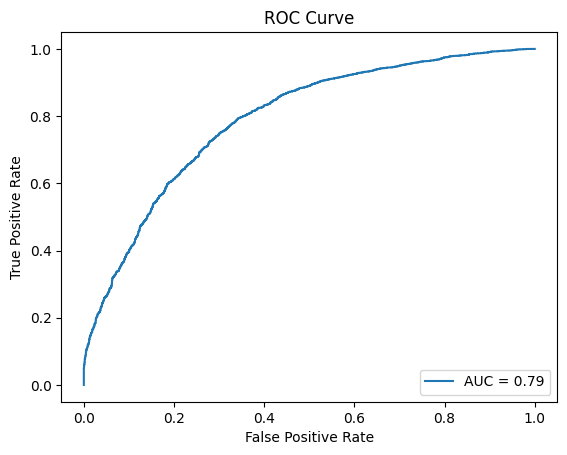

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Helper functions
def plot_auc(y_true, y_scores):
    """Plot the ROC AUC curve."""
    auc_score = roc_auc_score(y_true, y_scores)
    print(f"ROC AUC Score: {auc_score:.4f}")
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Model creation function
def create_vgg16_model(num_classes):
    model = models.vgg16(pretrained=True)
    
    # Freeze the convolutional layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Modify the classifier to match the number of classes
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    
    return model

# Training function
def train_vgg16(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):
    model = model.to(device)
    best_accuracy = 0.0
    best_model_wts = model.state_dict()
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Track statistics
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
        # Save the model if it has the best accuracy so far
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = model.state_dict()
            early_stop_counter = 0  # Reset counter when validation improves
        else:
            early_stop_counter += 1
        
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break
    
    # Load the best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_vgg16_model.pth')
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Testing function
def test_vgg16(model, test_loader, device, class_names):
    """Test the model and plot metrics."""
    model.eval()
    test_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Assuming binary classification
            
            test_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    test_acc = test_corrects.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Plot the confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)
    
    # Plot the ROC AUC curve
    plot_auc(all_labels, all_probs)

# Main workflow
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 224

train_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/train'
val_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/val'
test_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/test'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
model = create_vgg16_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

train_vgg16(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5)
model.load_state_dict(torch.load('best_vgg16_model.pth'))
test_vgg16(model, test_loader, device, class_names)


**VGG16 Test Accuracy = 78%**

**Resnet50 (AUC,CONFUSION_MATRIX)**

**RESNET50**

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


Epoch 1/50
Training Loss: 0.5524, Training Accuracy: 0.7330
Validation Loss: 0.3962, Validation Accuracy: 0.8663
Epoch 2/50
Training Loss: 0.5279, Training Accuracy: 0.7429
Validation Loss: 0.3702, Validation Accuracy: 0.8612
Epoch 3/50
Training Loss: 0.5215, Training Accuracy: 0.7461
Validation Loss: 0.3726, Validation Accuracy: 0.8622
Epoch 4/50
Training Loss: 0.5163, Training Accuracy: 0.7520
Validation Loss: 0.3818, Validation Accuracy: 0.8607
Epoch 5/50
Training Loss: 0.5085, Training Accuracy: 0.7526
Validation Loss: 0.3749, Validation Accuracy: 0.8678
Epoch 6/50
Training Loss: 0.5092, Training Accuracy: 0.7524
Validation Loss: 0.4062, Validation Accuracy: 0.8582
Epoch 7/50
Training Loss: 0.5096, Training Accuracy: 0.7516
Validation Loss: 0.3736, Validation Accuracy: 0.8492
Epoch 8/50
Training Loss: 0.5035, Training Accuracy: 0.7547
Validation Loss: 0.3884, Validation Accuracy: 0.8567
Epoch 9/50
Training Loss: 0.5053, Training Accuracy: 0.7552
Validation Loss: 0.3672, Validation 

/tmp/ipykernel_30/1848925164.py:201: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet50_model.pth'))


Test Accuracy: 0.7269


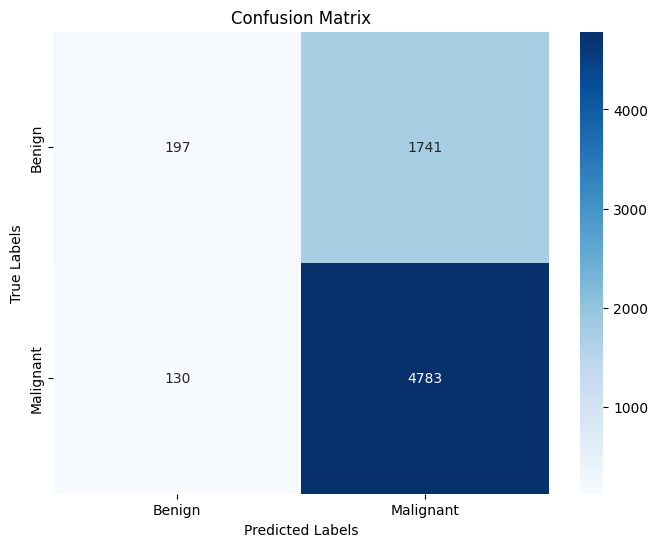

ROC AUC Score: 0.7358


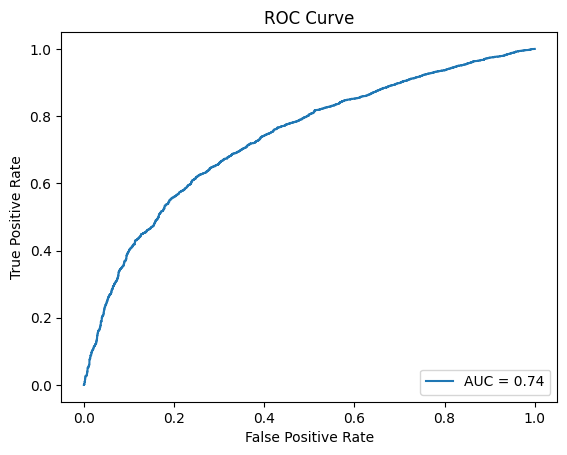

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Helper functions (same as provided)
def plot_auc(y_true, y_scores):
    """Plot the ROC AUC curve."""
    auc_score = roc_auc_score(y_true, y_scores)
    print(f"ROC AUC Score: {auc_score:.4f}")
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Model creation function for ResNet-50
def create_resnet50_model(num_classes):
    model = models.resnet50(pretrained=True)
    
    # Freeze the convolutional layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the fully connected layer to match the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

# Training function
def train_resnet50(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):
    model = model.to(device)
    best_accuracy = 0.0
    best_model_wts = model.state_dict()
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Track statistics
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
        # Save the model if it has the best accuracy so far
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = model.state_dict()
            early_stop_counter = 0  # Reset counter when validation improves
        else:
            early_stop_counter += 1
        
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break
    
    # Load the best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_resnet50_model.pth')
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Testing function
def test_resnet50(model, test_loader, device, class_names):
    """Test the model and plot metrics."""
    model.eval()
    test_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Assuming binary classification
            
            test_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    test_acc = test_corrects.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Plot the confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)
    
    # Plot the ROC AUC curve
    plot_auc(all_labels, all_probs)

# Main workflow
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 224

train_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/train'
val_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/val'
test_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/test'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
model = create_resnet50_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

train_resnet50(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5)
model.load_state_dict(torch.load('best_resnet50_model.pth'))
test_resnet50(model, test_loader, device, class_names)


**RESNET50 Test Accuracy = 73%**

**Resnet18 (AUC,CONFUSION_MATRIX)**

**RESNET 18**

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
Training Loss: 0.5746, Training Accuracy: 0.7186
Validation Loss: 0.4248, Validation Accuracy: 0.8286
Epoch 2/50
Training Loss: 0.5422, Training Accuracy: 0.7362
Validation Loss: 0.4382, Validation Accuracy: 0.8205
Epoch 3/50
Training Loss: 0.5261, Training Accuracy: 0.7437
Validation Loss: 0.4172, Validation Accuracy: 0.8220
Epoch 4/50
Training Loss: 0.5218, Training Accuracy: 0.7487
Validation Loss: 0.4079, Validation Accuracy: 0.8230
Epoch 5/50
Training Loss: 0.5158, Training Accuracy: 0.7494
Validation Loss: 0.4133, Validation Accuracy: 0.8215
Epoch 6/50
Training Loss: 0.5120, Training Accuracy: 0.7536
Validation Loss: 0.4250, Validation Accuracy: 0.8175
Early stopping triggered.
Best Validation Accuracy: 0.8286


/tmp/ipykernel_30/2239836128.py:201: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet18_model.pth'))


Test Accuracy: 0.7551


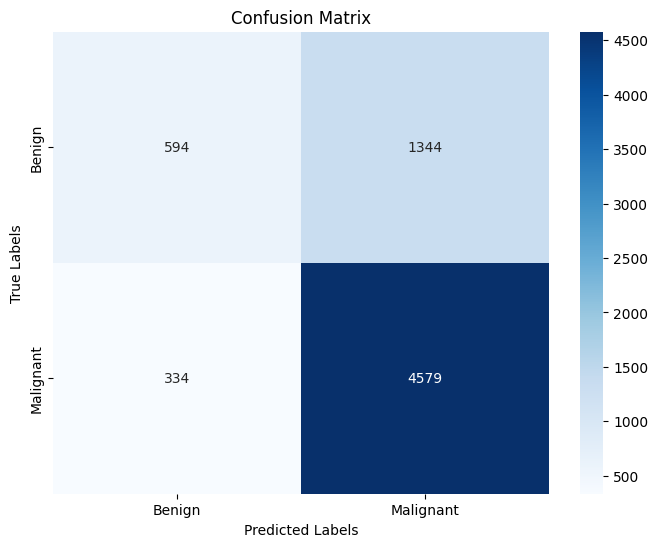

ROC AUC Score: 0.7397


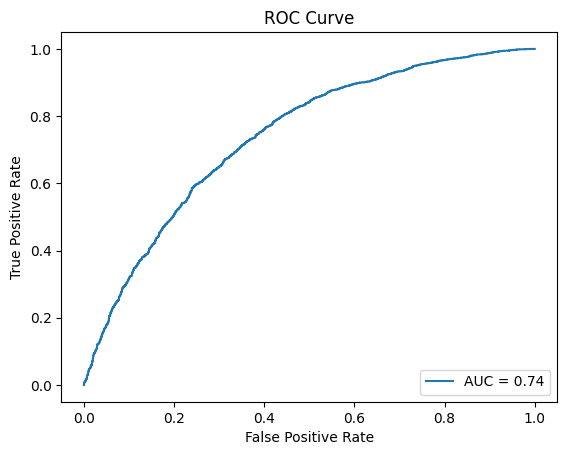

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Helper functions (same as provided)
def plot_auc(y_true, y_scores):
    """Plot the ROC AUC curve."""
    auc_score = roc_auc_score(y_true, y_scores)
    print(f"ROC AUC Score: {auc_score:.4f}")
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Model creation function for ResNet-18
def create_resnet18_model(num_classes):
    model = models.resnet18(pretrained=True)
    
    # Freeze the convolutional layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the fully connected layer to match the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

# Training function
def train_resnet18(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):
    model = model.to(device)
    best_accuracy = 0.0
    best_model_wts = model.state_dict()
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Track statistics
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
        # Save the model if it has the best accuracy so far
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = model.state_dict()
            early_stop_counter = 0  # Reset counter when validation improves
        else:
            early_stop_counter += 1
        
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break
    
    # Load the best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_resnet18_model.pth')
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Testing function
def test_resnet18(model, test_loader, device, class_names):
    """Test the model and plot metrics."""
    model.eval()
    test_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Assuming binary classification
            
            test_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    test_acc = test_corrects.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Plot the confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)
    
    # Plot the ROC AUC curve
    plot_auc(all_labels, all_probs)

# Main workflow
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 224

train_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/train'
val_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/val'
test_dir = '/kaggle/input/breast-cancer-dataset/clasification-roi/test'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
model = create_resnet18_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

train_resnet18(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5)
model.load_state_dict(torch.load('best_resnet18_model.pth'))
test_resnet18(model, test_loader, device, class_names)


**RESNET18 Test Accuracy = 78%**

**Using gradio library on two models(resnet50,resnet18)**

In [6]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 101.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
  Attempting uninstall: python-multipart
    Found existing installation: python-multipart 0.0.9
    Uninstalling python-multipart-0.0.9:
      Successfully uninstalled python-multipart-0.0.9
  Attempting uninstall: starlette
    Found existing installation: starlette 0.37.2
    Uninstalling starlette-0.37.2:
      Successfully uninstalled starlette-0.37.2
  Attempting uninstall: fastapi
    Found existing installation: f

In [7]:
import gradio as gr
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms

# Load your trained model dynamically
def load_model(model_name, model_path):
    if model_name == "ResNet18":
        model = models.resnet18(pretrained=False)  # Use pretrained=False for your custom-trained models
        model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
    elif model_name == "ResNet50":
        model = models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
    else:
        raise ValueError("Invalid model name.")
    
    # Load your trained model weights
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Preprocessing function for input images
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Prediction function
def predict(image, model_name):
    image = Image.fromarray(image)  # Convert numpy array to PIL image
    input_tensor = preprocess_image(image)
    
    # Map model names to weight file paths
    model_paths = {
        "ResNet18": "/kaggle/input/resnet_18/pytorch/default/1/best_resnet18_model.pth",
        "ResNet50": "/kaggle/input/resnet50_model/pytorch/default/1/best_resnet50_model.pth"
    }
    
    model_path = model_paths[model_name]
    model = load_model(model_name, model_path)
    
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        
        # Extract class names and their respective probabilities
        benign_prob = probabilities[0].item()
        malignant_prob = probabilities[1].item()
        predicted_idx = probabilities.argmax().item()
        predicted_class = class_names[predicted_idx]
    
    # Create a response string
    response = (
        f"Model: {model_name}\n"
        f"Predicted Class: {predicted_class}\n"
        f"Benign Probability: {benign_prob:.2f}\n"
        f"Malignant Probability: {malignant_prob:.2f}"
    )
    return response

# Define global variables
class_names = ["benign", "malignant"]  # Binary classes

# Define the Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Image(type="numpy", label="Upload Image"),
        gr.Radio(["ResNet18", "ResNet50"], label="Select Model")
    ],
    outputs=gr.Textbox(label="Prediction"),
    title="Breast Cancer Classification",
    description="Upload an image and select a model (ResNet18 or ResNet50) to classify it as benign or malignant."
)

# Launch the Gradio app
interface.launch()


* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://e6ae47426b59464e78.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_30/4111431873.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Installing Library

In [2]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 106.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
  Attempting uninstall: python-multipart
    Found existing installation: python-multipart 0.0.9
    Uninstalling python-multipart-0.0.9:
      Successfully uninstalled python-multipart-0.0.9
  Attempting uninstall: starlette
    Found existing installation: starlette 0.37.2
    Uninstalling starlette-0.37.2:
      Successfully uninstalled starlette-0.37.2
  Attempting uninstall: fastapi
    Found existing installation: f

**Using gradio library on all three models(resnet50,resnet18,vgg16)**

In [3]:
import gradio as gr
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms

# Load your trained model dynamically
def load_model(model_name, model_path):
    if model_name == "ResNet18":
        model = models.resnet18(pretrained=False)  # Use pretrained=False for your custom-trained models
        model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
    elif model_name == "ResNet50":
        model = models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
    elif model_name == "VGG16":
        model = models.vgg16(pretrained=False)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)  # Binary classification
    else:
        raise ValueError("Invalid model name.")
    
    # Load your trained model weights
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Preprocessing function for input images
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Prediction function
def predict(image, model_name):
    image = Image.fromarray(image)  # Convert numpy array to PIL image
    input_tensor = preprocess_image(image)
    
    # Map model names to weight file paths
    model_paths = {
        "ResNet18": "/kaggle/input/resnet_18/pytorch/default/1/best_resnet18_model.pth",
        "ResNet50": "/kaggle/input/resnet50_model/pytorch/default/1/best_resnet50_model.pth",
        "VGG16": "/kaggle/input/vgg_16_model/pytorch/default/1/best_vgg16_model.pth"
    }
    
    model_path = model_paths[model_name]
    model = load_model(model_name, model_path)
    
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        
        # Extract class names and their respective probabilities
        benign_prob = probabilities[0].item()
        malignant_prob = probabilities[1].item()
        predicted_idx = probabilities.argmax().item()
        predicted_class = class_names[predicted_idx]
    
    # Create a response string
    response = (
        f"Model: {model_name}\n"
        f"Predicted Class: {predicted_class}\n"
        f"Benign Probability: {benign_prob:.2f}\n"
        f"Malignant Probability: {malignant_prob:.2f}"
    )
    return response

# Define global variables
class_names = ["benign", "malignant"]  # Binary classes

# Define the Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Image(type="numpy", label="Upload Image"),
        gr.Radio(["ResNet18", "ResNet50", "VGG16"], label="Select Model")
    ],
    outputs=gr.Textbox(label="Prediction"),
    title="Breast Cancer Classification",
    description="Upload an image and select a model (ResNet18, ResNet50, or VGG16) to classify it as benign or malignant."
)

# Launch the Gradio app
interface.launch()


* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://919aafa643e734be5e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_30/1561323236.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

**------------------------------------------------------------------------------------------------**

**VGG16 IS THE BEST ACCURACY MODEL WITH 78 PERCENT**

**------------------------------------------------------------------------------------------------**